In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

%matplotlib inline
%load_ext line_profiler

In [2]:
df = pd.read_csv('data/load_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].apply(lambda dt: dt.year)
df['month'] = df['timestamp'].apply(lambda dt: dt.month)
df['day'] = df['timestamp'].apply(lambda dt: dt.day)

In [3]:
max_by_month = df.groupby(['year', 'month']).apply(lambda g: np.max(g['kwh'])).reset_index()
max_by_month.rename(columns={0:'kwh'}, inplace=True)

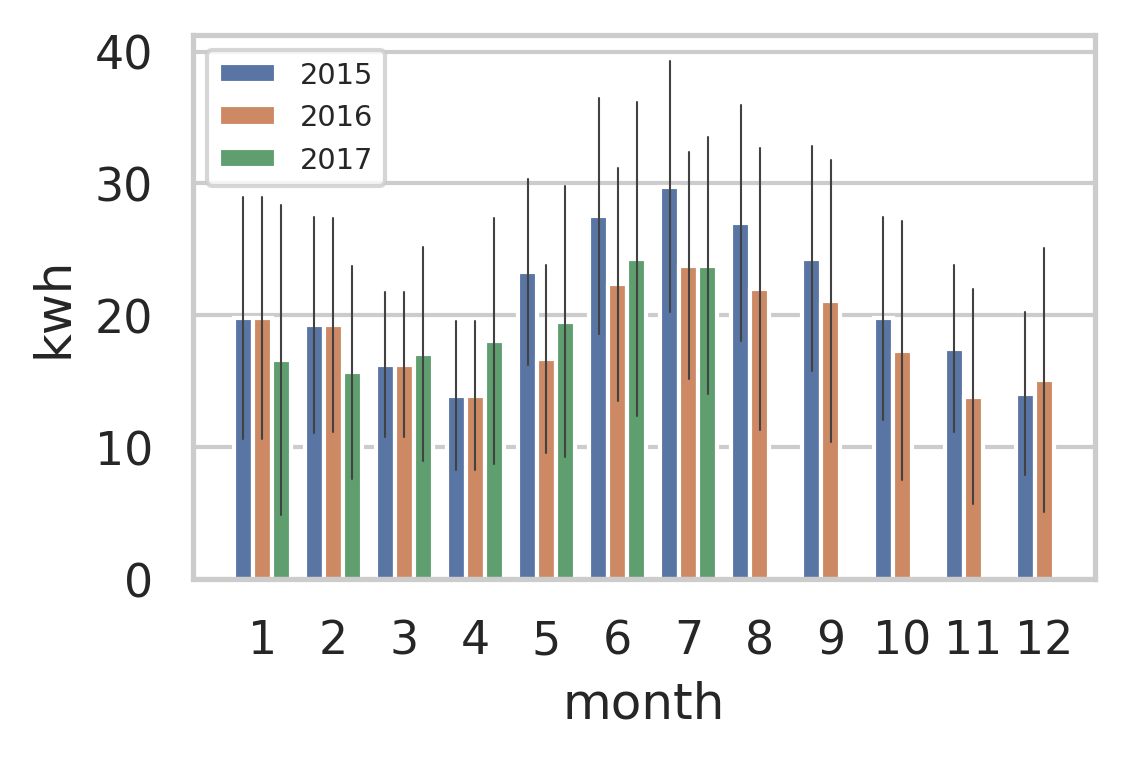

In [4]:
fig, ax = plt.subplots(figsize=(3.88, 2.4), dpi=300)

sns.barplot(x='month', y='kwh', hue='year', data=df, estimator=np.mean, ci='sd', errwidth=.5)
ax.legend(loc=2, fontsize='x-small')
ax.plot();

# Look at monthly

In [5]:
# july 2015
demand = df[(df.year == 2015) & (df.month == 7)].kwh.values

In [139]:
battery_max = 120
population_size = 500
top_percent = 0.3

In [90]:
def initial_population(battery_charge=None, size=None):
    assert size is not None
    assert type(size) is tuple or type(size) is list
    assert len(size) == 2
    
    row, col = size
    if battery_charge:
        low, high = -battery_charge, battery_charge
    else:
        low, high = -10, 10
        
    pop = np.random.uniform(low=low, high=high, size=(row, col))
    # Assign initial battery charge
    if battery_charge:
        pop[:, 0] = battery_charge
    return pop

In [111]:
def objective(monthly_usage, population):
    assert type(monthly_usage) is np.ndarray
    assert type(population) is np.ndarray
    assert monthly_usage.shape[0] == population.shape[1] 
    
    
    delta_threshold = monthly_usage - population 
    
    return np.abs(120 - (np.max(delta_threshold, axis=1) - np.min(delta_threshold, axis=1)))

In [98]:
def fitness(population, objective):
    return np.argsort(objective)

In [137]:
def next_generation(population, obj, fit, top_percent):
    # Top percentage of population
    pop_size, genome_length = population.shape
    to_slice = np.int(pop_size * top_percent)
    
    # Get parents
    parents = population[fit[:to_slice]]
    
    # Create population array for next generation by sampling index from uniform dist
    random_parent_index = np.random.randint(low=0, high=to_slice, size=pop_size)
    next_generation = parents[random_parent_index]
    
    # Parent splitting and shuffle
    cohort_1 = next_generation[:, :(genome_length // 2)]
    cohort_2 = next_generation[:, (genome_length // 2):]
    np.random.shuffle(cohort_1)
    np.random.shuffle(cohort_2)
    
    # Crossover
    next_generation[:, :(genome_length // 2)] = cohort_1
    next_generation[:, (genome_length // 2):] = cohort_2
    
    # Mutations
    mutate_prob = .03
    mutation_weights = [1 - mutate_prob, mutate_prob]
    mutations = np.random.normal(loc=0, scale=1, size=population.shape)
    likelihood = np.random.choice([0., 1.], size=population.shape, p=mutation_weights)
    
    next_generation += mutations * likelihood
    
    
    # Crossover
    return next_generation
    

In [133]:
#population = initial_population(size=(population_size, len(demand)))
population = initial_population(size=(10, 5))

#obj = objective(demand, population)
dmd = np.random.normal(loc=10, scale=5, size=(5,))
            
obj = objective(dmd, population)

fit = fitness(population, obj)

for cycle in range(100):
        obj = objective(dmd, population)
        fit = fitness(population, obj)
        population = next_generation(population, obj, fit, top_percent)
        
        #print(np.mean(obj))

In [141]:
population = initial_population(size=(population_size, len(demand)))
best = list()
means = list()
std = list()
for cycle in range(500):
    obj = objective(demand, population)
    fit = fitness(population, obj)
    population = next_generation(population, obj, fit, top_percent)

    if cycle % 10 == 0:
        #mean_fit = np.mean(fit)
        #means.append(mean_fit)
        #std_fit = np.std(fit)
        #std.append(std_fit)
        best_fit = obj[np.argmin(fit)]
        best.append(np.min(obj))
        
        
    
    if cycle % 400 == 0:
        params = dict(cycle=cycle, mean=mean_fit, std=std_fit, best=best_fit)
        print('{cycle}. Best: {best}'.format(**params))


0. Best: 65.19159088690223
400. Best: 1.968892291870361e-05
800. Best: 5.21754103033345e-07
1200. Best: 5.21754103033345e-07
1600. Best: 5.21754103033345e-07
2000. Best: 5.21754103033345e-07
2400. Best: 5.21754103033345e-07
2800. Best: 5.21754103033345e-07
3200. Best: 5.21754103033345e-07
3600. Best: 5.21754103033345e-07
4000. Best: 5.21754103033345e-07


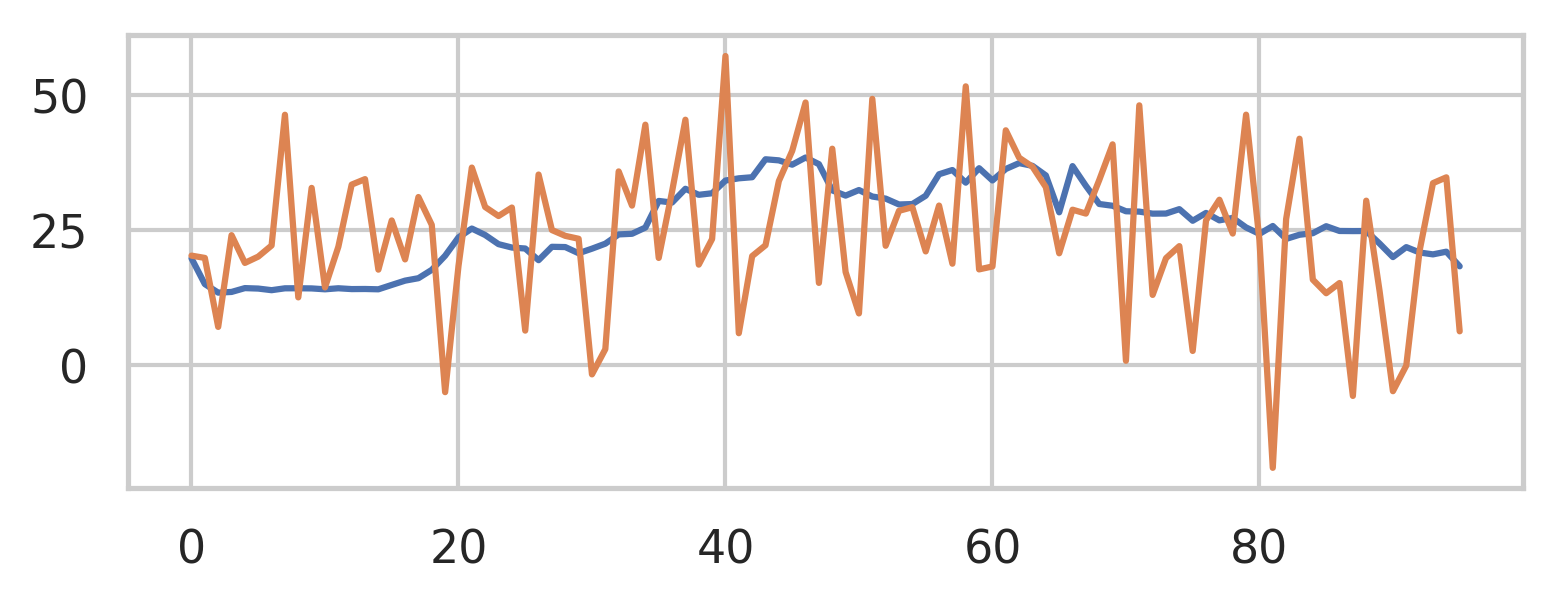

In [148]:
fig, ax = plt.subplots(figsize=(6, 2), dpi=300)
plt.plot(demand[:96])
plt.plot((demand - best)[:96])

In [151]:
np.min(np.cumsum(best))

-174.88954423703902

In [142]:
best = population[np.argmin(fit)] 

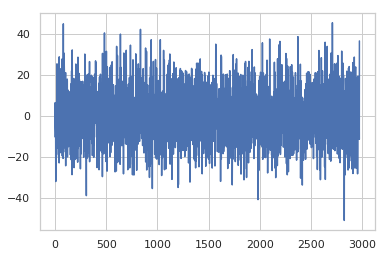

In [155]:
plt.plot(best)

In [171]:
from peakshave.api.battery import Battery
from peakshave.api.environment import Environment

In [ ]:
batt = Battery(max_capacity=120, max_flux=120)
threshold = 30
shaved_dmd = list()
for dmd in demand:
    if dmd > threshold:
        delta = dmd - threshold
        reserve = batt.current_level
        
        if delta > reserve:
            shaved = dmd - reserve
            batt.drain()
        else:
            shaved = threshold
            batt - delta
        
        append.shaved_dmd